# TOBIT Model

In [ ]:
import jax 
from jax import lax
from jax import random
import jax.numpy as jnp

In [ ]:
# gen data
key = random.PRNGKey(0)
x_key, noise_key = random.split(key, 2)
x = random.normal(x_key, (10000, 3))
beta = jnp.array([1.0, -1.5, 0.5])
noise = random.normal(noise_key, (10000,))

In [ ]:
noise = noise * 0.5
sigma = 0.5

(array([   5.,   73.,  379., 1357., 2782., 2912., 1776.,  602.,   96.,
          18.]),
 array([-2.0254457 , -1.6314368 , -1.2374281 , -0.8434192 , -0.44941038,
        -0.05540156,  0.33860725,  0.73261607,  1.126625  ,  1.5206337 ,
         1.9146426 ], dtype=float32),
 <a list of 10 Patch objects>)

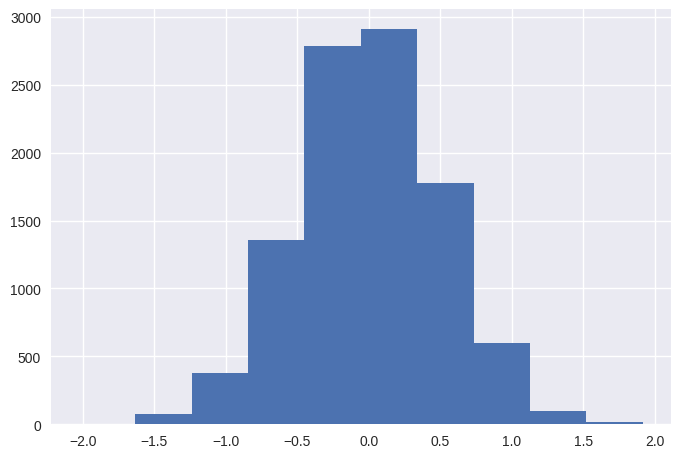

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn") 
plt.rcParams['figure.dpi'] = 100 
plt.hist(noise)

In [ ]:
# The truth
y = x @ beta.T + noise

In [ ]:
sum(y<0)

5013

In [ ]:
# censored
y = jnp.where(y < 0, 0, y)

In [ ]:
sum(y<0)

0

![Imgur](https://imgur.com/aAiXHPV.png)


In [ ]:
import jax.scipy.stats

def predict(beta, x):
    return x @ beta

def loss(beta, sigma):
    preds = predict(beta, x)
    return -jnp.sum((y > 0) * (-0.5 * jnp.log(2 * jnp.pi) -0.5 * jnp.log(sigma ** 2) - (0.5/(sigma ** 2)) * ((y - preds)**2)) \
                   + (y == 0) * (jnp.log(1 - jax.scipy.stats.norm.cdf(preds/sigma) + 1e-7))) / 10000.
    

In [ ]:
loss(beta, sigma)

DeviceArray(0.45323795, dtype=float32)

In [ ]:
key = random.PRNGKey(1)
beta_test = random.normal(key, (3,))

sigma_test = 5.00
loss(beta_test, sigma_test)

DeviceArray(1.5846142, dtype=float32)

- The loss of true parameters are smaller than that of the random ones.

![img](https://i.imgur.com/Y4coYGh.png)

In [ ]:
def grad_beta(beta, sigma):
    preds = x @ beta
    first_part = (y > 0) * (y - preds)
    second_part = (y == 0) * (sigma * jax.scipy.stats.norm.pdf(preds / sigma)) / (1 - jax.scipy.stats.norm.cdf(preds/ sigma) + 1e-7) # in case divided by 0
    
    return -(x.T @ (first_part - second_part))/ (sigma**2) / 10000.00


def grad_sigma(beta, sigma):
    preds = x @ beta
    first_part = (y > 0) * (- 0.5 / sigma**2 + (y - preds)**2 / (2 * sigma ** 4))
    second_part = (y == 0) * (jax.scipy.stats.norm.pdf(preds / sigma) * preds) / ((1 - jax.scipy.stats.norm.cdf(preds/ sigma)) * 2 * sigma**3 + 1e-7) # in case divided by 0
    grad_sigma_squared = (first_part + second_part)
    
    return -jnp.sum(grad_sigma_squared * sigma * 2.) / 10000.00

In [ ]:
grad_beta(beta, sigma)

DeviceArray([ 0.00766604, -0.01479468, -0.036193  ], dtype=float32)

In [ ]:
# check grad using autograd
b_grad = jax.grad(loss)(beta, sigma)
b_grad

DeviceArray([ 0.00766604, -0.0147947 , -0.03619297], dtype=float32)

In [ ]:
grad_sigma(beta, sigma)

DeviceArray(-0.0010352, dtype=float32)

In [ ]:
# check grad by using autograd
s_grad = jax.grad(loss, 1)(beta, sigma)
s_grad

DeviceArray(-0.00103992, dtype=float32)

In [ ]:
# verify that the random parameter has larger grad than the true one
grad_beta(beta_test, sigma_test)

DeviceArray([-0.04763903,  0.05923318,  0.01350343], dtype=float32)

In [ ]:
grad_sigma(beta_test, sigma_test)

DeviceArray(0.0978766, dtype=float32)

## 1. Tobit with Gradient Descent

In [ ]:
beta_test

DeviceArray([ 0.17269011, -0.6476558 ,  1.2229711 ], dtype=float32)

In [ ]:
current_loss = loss(beta_test, sigma_test)
current_loss

DeviceArray(1.5846142, dtype=float32)

In [ ]:
beta_grad = grad_beta(beta_test, sigma_test)
sigma_grad = grad_sigma(beta_test, sigma_test)

In [ ]:
lr = 0.1
beta_test_new = beta_test - lr * beta_grad
sigma_test_new = sigma_test - lr * sigma_grad

In [ ]:
# verify that the loss decreases after a small step 
new_loss = loss(beta_test_new, sigma_test_new)
new_loss

DeviceArray(1.5830587, dtype=float32)

In [ ]:
def gradient_descent(beta_init, sigma_init, max_iter, eps, lr):
    converged = False
    beta_old = beta_init
    beta_new = beta_init
    sigma_old = sigma_init
    sigma_new = sigma_init
    
    current_iter = 0
    while not converged and current_iter < max_iter:
        print("Current iteration is %d"% current_iter)
        beta_copy = beta_old 
        sigma_copy = sigma_old
        current_loss = loss(beta_copy, sigma_copy) 
        current_beta_grad = grad_beta(beta_copy, sigma_copy)
        current_sigma_grad = grad_sigma(beta_copy, sigma_copy)
        beta_new = beta_copy - lr * current_beta_grad
        sigma_new = sigma_copy - lr * current_sigma_grad
        new_loss = loss(beta_new, sigma_new)
        diff = jnp.abs(new_loss-current_loss)
        print("The difference is %.5f"%diff)
        beta_old = beta_new
        sigma_old  = sigma_new
        if diff <= eps:   
            converged = True
            print("Algorithm converged")
            break
        else:
            current_iter +=1
            if current_iter >= max_iter:
                print("The algorithm have failed to converge.")
                break

    return beta_new, sigma_new, converged

In [ ]:
max_iter = 1000
eps = 1e-4
lr = 0.01

In [ ]:
# test our algo with parameters close to the truth
beta_test = jnp.array([0.9, -1.4, 0.55])
sigma_test = 0.44

In [ ]:
gradient_descent(beta_test, sigma_test, max_iter, eps, lr)

Current iteration is 0
The difference is 0.00343
Current iteration is 1
The difference is 0.00293
Current iteration is 2
The difference is 0.00253
Current iteration is 3
The difference is 0.00220
Current iteration is 4
The difference is 0.00193
Current iteration is 5
The difference is 0.00171
Current iteration is 6
The difference is 0.00152
Current iteration is 7
The difference is 0.00136
Current iteration is 8
The difference is 0.00122
Current iteration is 9
The difference is 0.00110
Current iteration is 10
The difference is 0.00100
Current iteration is 11
The difference is 0.00091
Current iteration is 12
The difference is 0.00083
Current iteration is 13
The difference is 0.00076
Current iteration is 14
The difference is 0.00070
Current iteration is 15
The difference is 0.00065
Current iteration is 16
The difference is 0.00060
Current iteration is 17
The difference is 0.00055
Current iteration is 18
The difference is 0.00051
Current iteration is 19
The difference is 0.00048
Current it

(DeviceArray([ 0.965977 , -1.46154  ,  0.5223337], dtype=float32),
 DeviceArray(0.4975379, dtype=float32),
 True)

In [ ]:
# Now for the real test
key = random.PRNGKey(2)
beta_test = random.normal(key, (3,))
sigma_test = 0.8

In [ ]:
max_iter = 1000
eps = 1e-4
lr = 0.01

In [ ]:
gradient_descent(beta_test, sigma_test, max_iter, eps, lr)

Current iteration is 0
The difference is 0.59521
Current iteration is 1
The difference is 0.34260
Current iteration is 2
The difference is 0.23249
Current iteration is 3
The difference is 0.17186
Current iteration is 4
The difference is 0.13402
Current iteration is 5
The difference is 0.10845
Current iteration is 6
The difference is 0.09018
Current iteration is 7
The difference is 0.07657
Current iteration is 8
The difference is 0.06610
Current iteration is 9
The difference is 0.05784
Current iteration is 10
The difference is 0.05118
Current iteration is 11
The difference is 0.04572
Current iteration is 12
The difference is 0.04118
Current iteration is 13
The difference is 0.03735
Current iteration is 14
The difference is 0.03409
Current iteration is 15
The difference is 0.03128
Current iteration is 16
The difference is 0.02884
Current iteration is 17
The difference is 0.02671
Current iteration is 18
The difference is 0.02483
Current iteration is 19
The difference is 0.02317
Current it

(DeviceArray([ 0.9817394, -1.454431 ,  0.505896 ], dtype=float32),
 DeviceArray(0.51087767, dtype=float32),
 True)

###  检查当 $\epsilon$ 为柯西分布时对整个估计的影响

In [ ]:
key = random.PRNGKey(0)
noise = random.cauchy(key, (10000,))
y = x @ beta + noise

(array([1.00e+00, 2.00e+00, 0.00e+00, 5.00e+00, 9.81e+03, 1.74e+02,
        5.00e+00, 1.00e+00, 0.00e+00, 2.00e+00]),
 array([-2190.4465  , -1748.516   , -1306.5854  ,  -864.6549  ,
         -422.72437 ,    19.206177,   461.13672 ,   903.06726 ,
         1344.9978  ,  1786.9283  ,  2228.859   ], dtype=float32),
 <a list of 10 Patch objects>)

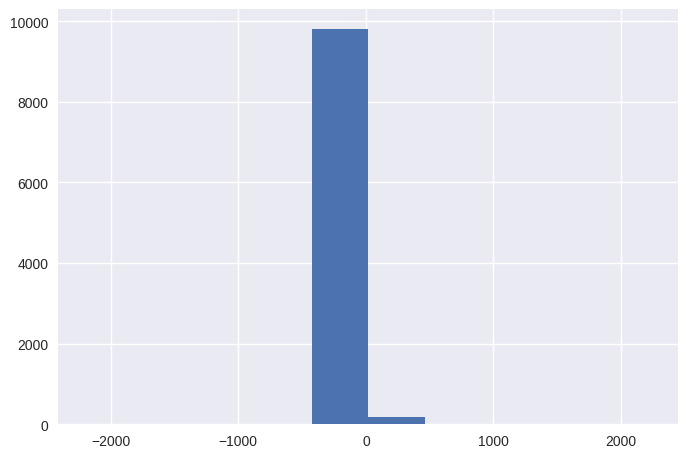

In [ ]:
plt.hist(noise)

In [ ]:
sum(y < 0)

5014

In [ ]:
y = jnp.where(y < 0, 0, y)

In [ ]:
sum(y >= 0)

10000

In [ ]:
# Test it with parameters close to the truth ones
beta_test = jnp.array([0.9, -1.4, 0.55])
sigma_test = 0.44
gradient_descent(beta_test, sigma_test, max_iter, 1e-4, lr)

Current iteration is 0
The difference is 3586.64893
Current iteration is 1
The difference is 0.00000
Algorithm converged


(DeviceArray([ 0.88520855, -1.410009  ,  0.53818995], dtype=float32),
 DeviceArray(163.59047, dtype=float32),
 True)

In [ ]:
loss(jnp.array([ 0.88520855, -1.410009  ,  0.53818995]), 163.59047)

DeviceArray(3.3710535, dtype=float32)

- It converged, but not to the truth: the converged sigma is far off from the truth; in fact, it seems that the model has to enlarge sigma to decrease loss.

In [ ]:
# Now try init a very small sigma
key = random.PRNGKey(222)
beta_test = random.normal(key, (3,))
sigma_test = 0.1
gradient_descent(beta_test, sigma_test, max_iter, 1e-4, 0.001)

Current iteration is 0
The difference is 69534.00000
Current iteration is 1
The difference is 0.00000
Algorithm converged


(DeviceArray([-0.366792  , -0.76456016,  0.8146489 ], dtype=float32),
 DeviceArray(1390.8322, dtype=float32),
 True)

In [ ]:
loss(jnp.array([-0.366792  , -0.76456016,  0.8146489]), 1390.8322)

DeviceArray(4.41469, dtype=float32)

- Still, converge by driving simga to an insanely large number.

In [ ]:
# Try some different sigma
sigma_test = 20
gradient_descent(beta_test, sigma_test, 1000, 1e-4, lr)

Current iteration is 0
The difference is 0.00022
Current iteration is 1
The difference is 0.00022
Current iteration is 2
The difference is 0.00022
Current iteration is 3
The difference is 0.00022
Current iteration is 4
The difference is 0.00022
Current iteration is 5
The difference is 0.00022
Current iteration is 6
The difference is 0.00022
Current iteration is 7
The difference is 0.00022
Current iteration is 8
The difference is 0.00022
Current iteration is 9
The difference is 0.00022
Current iteration is 10
The difference is 0.00022
Current iteration is 11
The difference is 0.00022
Current iteration is 12
The difference is 0.00022
Current iteration is 13
The difference is 0.00022
Current iteration is 14
The difference is 0.00022
Current iteration is 15
The difference is 0.00022
Current iteration is 16
The difference is 0.00022
Current iteration is 17
The difference is 0.00022
Current iteration is 18
The difference is 0.00022
Current iteration is 19
The difference is 0.00022
Current it

(DeviceArray([-0.34297225, -0.79282606,  0.86288804], dtype=float32),
 DeviceArray(21.330193, dtype=float32),
 False)

In [ ]:
loss(jnp.array([-0.34297225, -0.79282606,  0.86288804]), 21.330193)

DeviceArray(3.8537128, dtype=float32)

- This time the model fails to converge.
### In short, cauchy noise hurts the model performance.

## 2. Tobit with Proximal methods + line search



In [ ]:
def soft_threshold(x, thres):
    return jax.lax.cond(x > thres,
                        lambda _: x - thres,
                        lambda _: jax.lax.cond(
                            x < -thres,
                            lambda _: x + thres,
                            lambda _:0.0,
                            None
                        ),
                        None)

In [ ]:
def proximal_methods_line_search(beta_init, sigma_init, max_iter, eps, penalty):
    converged = False
    beta_old = beta_init
    beta_new = beta_init
    sigma_old = sigma_init
    sigma_new = sigma_init
    soft_threshold_partial = lambda x: soft_threshold(x, lr*penalty)
    current_iter = 0
    new_loss = 100000
    while not converged and current_iter < max_iter:
        print("Current iteration is %d"% current_iter)
        beta_copy = beta_old
        sigma_copy = sigma_old
        current_loss = loss(beta_copy, sigma_copy) + penalty*jnp.linalg.norm(beta_copy, 1)
        
        lr = 1.
        while True:                       
            current_beta_grad = grad_beta(beta_copy, sigma_copy)
            wb = beta_copy - lr*current_beta_grad
            beta_new = jax.vmap(soft_threshold_partial, 0)(wb)

            current_sigma_grad = grad_sigma(beta_copy, sigma_copy)
            ws = sigma_copy - lr*current_sigma_grad

            # TODO Not sure if this is correct
            current_grad = jnp.concatenate((current_beta_grad, jnp.array([current_sigma_grad])), axis=0)
            old_pars = jnp.concatenate((beta_copy, jnp.array([sigma_copy])), axis=0)
            new_pars = jnp.concatenate((beta_new, jnp.array([sigma_new])), axis=0)

            G = (old_pars - new_pars) / lr
            if loss(beta_new, sigma_new) <= loss(beta_copy, sigma_copy) - lr * (current_grad.T @ G) + 0.5 * jnp.linalg.norm(G, 2):
                break
            else:
                lr *= decay

        new_loss = loss(beta_new, sigma_new) + penalty*jnp.linalg.norm(beta_new, 1)
        diff = jnp.abs(new_loss-current_loss)
        print("The difference is %.5f"%diff)
        beta_old = beta_new
        if diff <= eps:   
            converged = True
            print("Algorithm converged")
            return beta_new, sigma_new
            break
        else:
            current_iter +=1
            if current_iter >= max_iter:
                print("The algorithm have failed to converge.")
                break

In [ ]:
decay = 0.5
penalty = 0.01
proximal_methods_line_search(beta_test, sigma_test, max_iter, eps, penalty)

Current iteration is 0
The difference is 0.00037
Current iteration is 1
The difference is 0.00037
Current iteration is 2
The difference is 0.00036
Current iteration is 3
The difference is 0.00036
Current iteration is 4
The difference is 0.00036
Current iteration is 5
The difference is 0.00036
Current iteration is 6
The difference is 0.00036
Current iteration is 7
The difference is 0.00036
Current iteration is 8
The difference is 0.00036
Current iteration is 9
The difference is 0.00035
Current iteration is 10
The difference is 0.00035
Current iteration is 11
The difference is 0.00035
Current iteration is 12
The difference is 0.00035
Current iteration is 13
The difference is 0.00035
Current iteration is 14
The difference is 0.00035
Current iteration is 15
The difference is 0.00035
Current iteration is 16
The difference is 0.00034
Current iteration is 17
The difference is 0.00034
Current iteration is 18
The difference is 0.00034
Current iteration is 19
The difference is 0.00034
Current it

(DeviceArray([ 0.        , -0.684329  ,  0.62621164], dtype=float32), 20)

- It has driven one of the beta to 0.

In [ ]:
decay = 0.5
penalty = 0.05
proximal_methods_line_search(beta_test, sigma_test, max_iter, eps, penalty)

Current iteration is 0
The difference is 0.00730
Current iteration is 1
The difference is 0.00727
Current iteration is 2
The difference is 0.00724
Current iteration is 3
The difference is 0.00720
Current iteration is 4
The difference is 0.00717
Current iteration is 5
The difference is 0.00714
Current iteration is 6
The difference is 0.00711
Current iteration is 7
The difference is 0.00467
Current iteration is 8
The difference is 0.00392
Current iteration is 9
The difference is 0.00391
Current iteration is 10
The difference is 0.00389
Current iteration is 11
The difference is 0.00388
Current iteration is 12
The difference is 0.00386
Current iteration is 13
The difference is 0.00384
Current iteration is 14
The difference is 0.00383
Current iteration is 15
The difference is 0.00381
Current iteration is 16
The difference is 0.00379
Current iteration is 17
The difference is 0.00250
Current iteration is 18
The difference is 0.00000
Algorithm converged


(DeviceArray([0., 0., 0.], dtype=float32), 20)

- With a larger penalty, all betas become 0.